In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common import make_data_dict, make_sur_map, make_bin_map, make_sur, myscore, cut_range, clean_parameters
from collections import OrderedDict

sensor_data = make_data_dict()

In [8]:
pre_map =  make_sur_map(sensor_data['S8'][0])
post_map =  make_sur_map(sensor_data['S8'][1])
BINNING_TYPE = '8'
df2 = pd.read_csv("data/bin_map/EllipticIRRAD{}.csv".format(BINNING_TYPE), skiprows=1, names=['col','row','bin'], sep=" ")
bin_map = make_bin_map(df2)
binsize = len(df2['bin'].unique())
pre = pd.merge(sensor_data['S8'][0], df2, on=['col','row'])
post = pd.merge(sensor_data['S8'][1], df2, on=['col','row'])

Text(0.5, 1.0, 'Sensor bins')

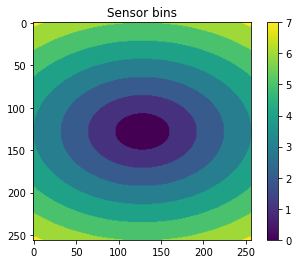

In [9]:
im = plt.imshow(bin_map)
plt.colorbar(im)
plt.title('Sensor bins')

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import crystalball, norm, skewnorm


class NoPcaSuroGen:
    
    _columns = ['p0','p1','c','t']
    
    def __init__(self):
        self.dist = crystalball
        self.fit_params = OrderedDict()
        self.fitted_gens = OrderedDict()
        self.scaler = StandardScaler()
        
        
    def transform(self, data):
        data = self.scaler.transform(data)
        return data
        
    def inverse_transform(self, data):
        data = self.scaler.inverse_transform(data)
        return data
        
    @staticmethod
    def prepare_data(data):
        pre_params = data[NoPcaSuroGen._columns]
        pre_cut_bin = cut_range(pre_params)
        return pre_cut_bin

    def _generate(self, size):
        arr = np.zeros((size, len(self._columns)))
        for j, col in enumerate(self._columns):
            arr[:,j] = self.fitted_gens[col](size)
        return arr
        
    def generate(self, size):
        arr = self._generate(size)
        generated = self.inverse_transform(arr)
        return generated
        
    def _fit(self, data):
        for j, col in enumerate(self._columns):
            d = data[:,j]
            d = d[~np.isnan(d)]
            p = self.dist.fit(d)
            self.fit_params[col] = p
            self.fitted_gens[col] = lambda x=1 : self.dist.rvs(*p,x)
        
    def fit(self, grouped_data):
        pre_cut_bin = self.prepare_data(grouped_data)
        data = self.scaler.fit_transform(pre_cut_bin)
        self._fit(data)
            
    def means(self):
        mean_arr = [self.dist.mean(*params) for params in self.fit_params.values()]
        mean_tran= self.inverse_transform([mean_arr])
        return mean_tran
    
class SuroGen(NoPcaSuroGen):
    
    _columns = ['p0','p1','c','t']
    
    def __init__(self):
        #self.dist = skewnorm
        NoPcaSuroGen.__init__(self)
        self.dist = skewnorm
        self.scaler = StandardScaler()
        self.pca = PCA(whiten=True)
        self.fit_params = OrderedDict()
        self.fitted_gens = OrderedDict()

    def transform(self, data):
        data = self.scaler.transform(data)
        data = self.pca.transform(data)
        return data

    def inverse_transform(self, data):
        data = self.pca.inverse_transform(data)
        data = self.scaler.inverse_transform(data)
        return data
    
    def fit(self, grouped_data):
        pre_cut_bin = self.prepare_data(grouped_data)
        data = self.scaler.fit_transform(pre_cut_bin)
        decor = self.pca.fit_transform(data)
        self._fit(decor)
    
    def generate_decor(self, size):
        return NoPcaSuroGen._generate(self, size)

    def generate(self, size):
        arr = self.generate_decor(size)
        generated = self.inverse_transform(arr)
        return generated
    
class SuroGen2(SuroGen):
    
    _columns = ['p0','p1','c','t']
    
    def __init__(self,pca):
        SuroGen.__init__(self)
        self.dist = skewnorm
        self.pca = pca
        self.fit_params = OrderedDict()
        self.fitted_gens = OrderedDict()

    
    def fit_alteration(total_data):
        pre_cut_bin = SuroGen2.prepare_data(total_data)
        scaler = StandardScaler()
        pca = PCA(whiten=True)
        data = scaler.fit_transform(pre_cut_bin)
        decor = pca.fit_transform(data)
        return scaler, pca
    
    def fit(self, grouped_data):
        pre_cut_bin = self.prepare_data(grouped_data)
        data = self.scaler.fit_transform(pre_cut_bin)
        decor = self.pca.transform(data)
        self._fit(decor)
    


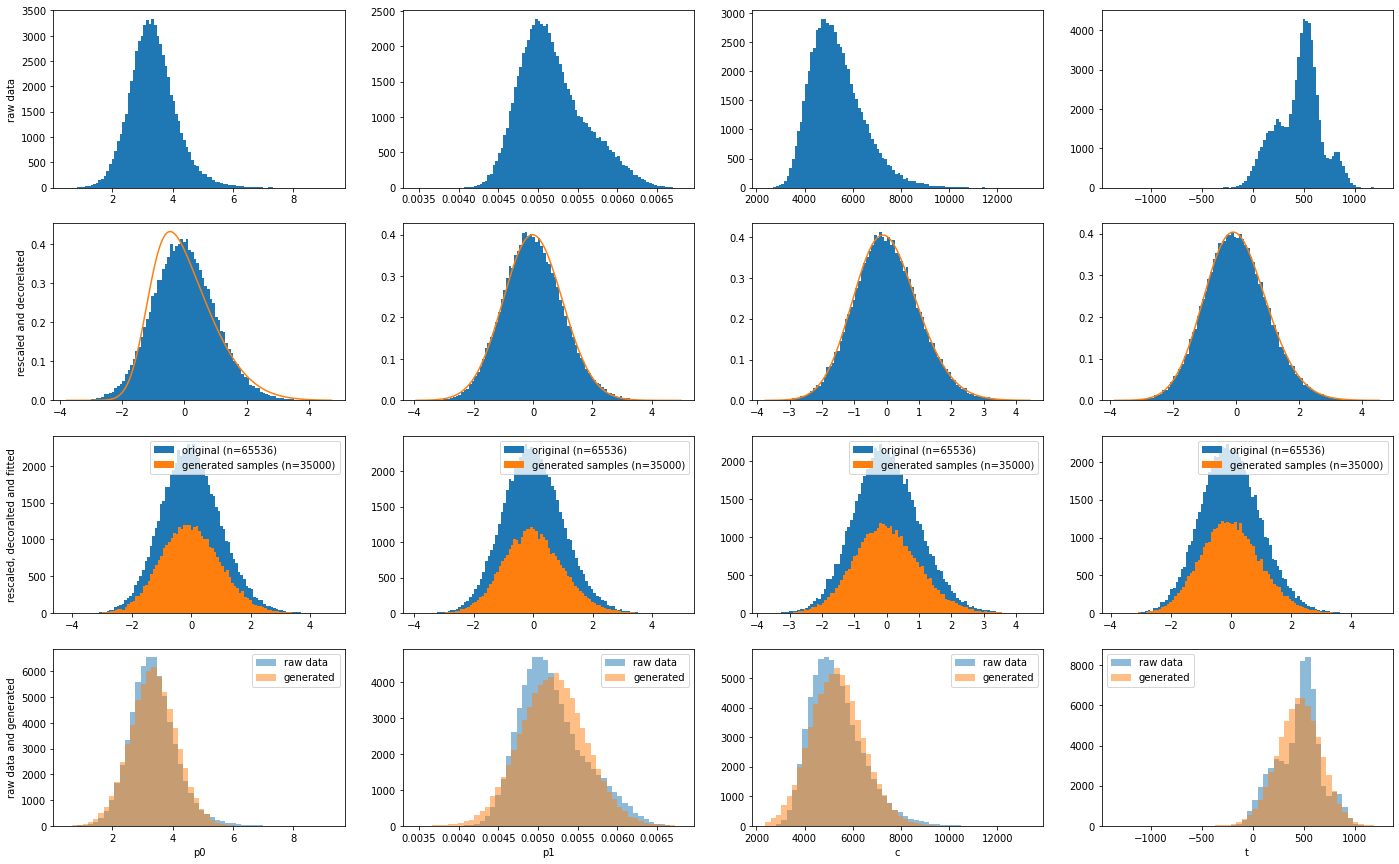

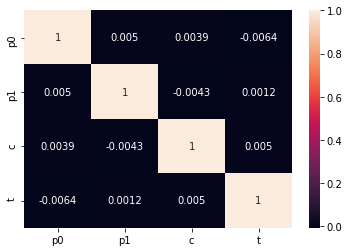

In [37]:
fig, ax = plt.subplots(4,4, figsize=(24,15))

axes = ax[0]
pre_cut = SuroGen.prepare_data(pre)
for m in range(4):
    axes[m].hist(pre_cut.values[:,m],bins=100)
    

GENSIZE = pre.shape[0]
axes = ax[3]
tmpbins = []
for m in range(4):
    _, bins, _  = axes[m].hist(pre_cut.values[:,m],bins=50, label="raw data", alpha=0.5)
    tmpbins.append(bins)
    
axes = ax[2]
sgn = SuroGen()
sgn.fit(pre)
decorelated = sgn.generate_decor(GENSIZE)
_ = axes[0].hist(decorelated[:,0], bins=100, label="original (n={})".format(GENSIZE))
_ = axes[1].hist(decorelated[:,1], bins=100, label="original (n={})".format(GENSIZE))
_ = axes[2].hist(decorelated[:,2], bins=100, label="original (n={})".format(GENSIZE))
_ = axes[3].hist(decorelated[:,3], bins=100, label="original (n={})".format(GENSIZE))

generated = np.zeros_like(decorelated)
axes = ax[1]
_ = axes[0].hist(decorelated[:,0], bins=100, density=True)
_ = axes[1].hist(decorelated[:,1], bins=100, density=True)
_ = axes[2].hist(decorelated[:,2], bins=100, density=True)
_ = axes[3].hist(decorelated[:,3], bins=100, density=True)


EXAMPLE_GENSIZE = 35000
exmpl = sgn.generate_decor(EXAMPLE_GENSIZE)
for j in range(4):
    data = decorelated[:,j]
    params = list(sgn.fit_params.items())[j][1]
    size = 1000 
    x = np.linspace(data.min(), data.max(), size)
    pdf_fitted = sgn.dist.pdf(x, *params) 
    axes = ax[1]
    axes[j].plot(x, pdf_fitted)
    # = dist.rvs(GENSIZE)
    example_gen = exmpl[:,j]
    axes = ax[2]
    axes[j].hist(example_gen, bins=100, label="generated samples (n={})".format(EXAMPLE_GENSIZE))
    axes[j].legend()
    
    
recor = sgn.generate(GENSIZE)
    
axes = ax[3]
for m in range(4):
    axes[m].hist(recor[:,m],bins=tmpbins[m], label="generated", alpha=0.5)
    axes[m].legend()

ax[0,0].set_ylabel("raw data")
ax[1,0].set_ylabel("rescaled and decorelated")
ax[2,0].set_ylabel("rescaled, decoralted and fitted")
ax[3,0].set_ylabel("raw data and generated")
ax[3,0].set_xlabel("p0")
ax[3,1].set_xlabel("p1")
ax[3,2].set_xlabel("c")
ax[3,3].set_xlabel("t")
fig.show()
import seaborn as sns
plt.figure()
corrMatrix = pd.DataFrame(data=decorelated, columns=SuroGen._columns).corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

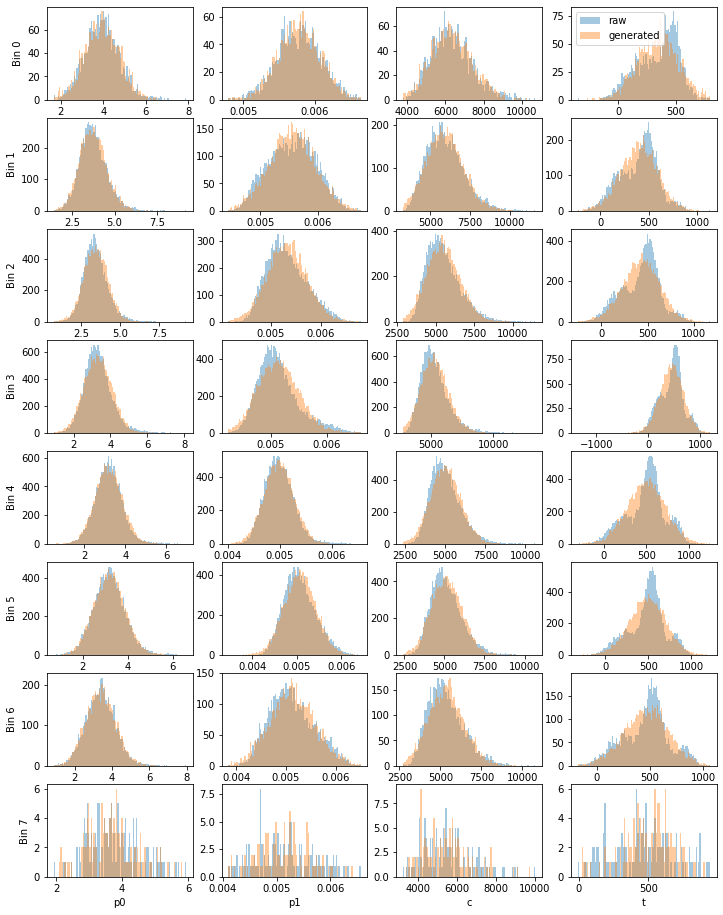

In [38]:
fig, ax = plt.subplots(binsize,4, figsize=(12,16))
dist = skewnorm
for i, (name, group) in enumerate(pre.groupby('bin')):
    axes = ax[i]
    pre_params = group[['p0','p1','c','t']]
    pre_cut_bin = cut_range(pre_params)
    surogen = SuroGen()
    surogen.fit(group)
    if i == 9:
        generated = group.values
    else:
        generated = surogen.generate(group.shape[0])

    _, b1, _ = axes[0].hist(pre_cut_bin.values[:,0], bins=100, alpha=0.4)
    _, b2, _ = axes[1].hist(pre_cut_bin.values[:,1], bins=100, alpha=0.4)
    _, b3, _ = axes[2].hist(pre_cut_bin.values[:,2], bins=100, alpha=0.4)
    _, b4, _ = axes[3].hist(pre_cut_bin.values[:,3], bins=100, alpha=0.4, label='raw')

    axes[0].hist(generated[:,0], bins=b1, alpha=0.4)
    axes[1].hist(generated[:,1], bins=b2, alpha=0.4)
    axes[2].hist(generated[:,2], bins=b3, alpha=0.4)
    axes[3].hist(generated[:,3], bins=b4, alpha=0.4, label='generated')
    axes[0].set_ylabel("Bin {}".format(name))

axes[0].set_xlabel('p0')
axes[1].set_xlabel('p1')
axes[2].set_xlabel('c')
axes[3].set_xlabel('t')
ax[0,3].legend()









Text(0.5, 141.00000000000014, 't')

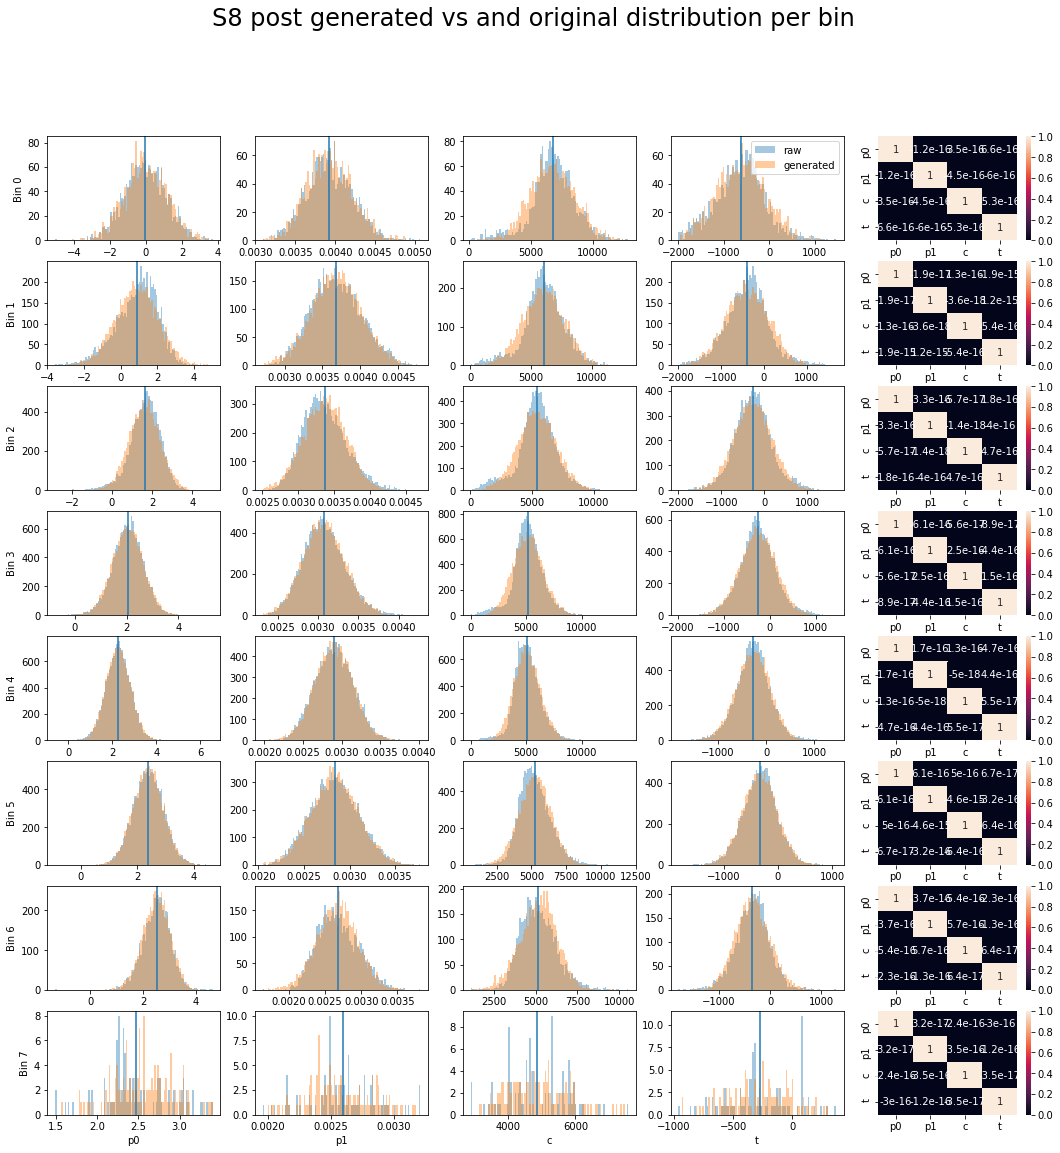

In [60]:
    
fig, ax = plt.subplots(binsize,5, figsize=(18,18))
generated_all = []

genmeans = []
gmeans_dict = {}
surogen_in_bin = {}
corr_in_bin = {}

#generated_to_save_all = {}
#params_in_bin = {}
post_surogen = {}
fig.suptitle("S8 post generated vs and original distribution per bin", fontsize=24)
for i, (name, group) in enumerate(post.groupby('bin')):
    if name==9:
        break
    axes = ax[i]
    pre_params = group[['p0','p1','c','t']]
    pre_cut_bin = cut_range(pre_params)
    surogen = SuroGen()
    surogen.fit(group)
    corr_in_bin[name] = surogen.pca.components_
    generated = surogen.generate(group.shape[0])
    surogen_in_bin[name] = surogen
    generated_all.append(generated)
    rmi = surogen.means()[0]
    genmeans.append(rmi)
    gmeans_dict[i] = rmi
    #print([v for v in surogen.fit_params.values()])
    #print(rmi)
    axes[0].axvline(rmi[0])
    axes[1].axvline(rmi[1])
    axes[2].axvline(rmi[2])
    axes[3].axvline(rmi[3])
    
    _, b1, _ = axes[0].hist(pre_cut_bin.values[:,0], bins=100, alpha=0.4)
    _, b2, _ = axes[1].hist(pre_cut_bin.values[:,1], bins=100, alpha=0.4)
    _, b3, _ = axes[2].hist(pre_cut_bin.values[:,2], bins=100, alpha=0.4)
    _, b4, _ = axes[3].hist(pre_cut_bin.values[:,3], bins=100, alpha=0.4, label='raw')

    axes[0].hist(generated[:,0], bins=b1, alpha=0.4)
    axes[1].hist(generated[:,1], bins=b2, alpha=0.4)
    axes[2].hist(generated[:,2], bins=b3, alpha=0.4)
    axes[3].hist(generated[:,3], bins=b4, alpha=0.4, label='generated')
    axes[0].set_ylabel("Bin {}".format(name))
    decorelated = surogen.transform(SuroGen.prepare_data(group))
    corrMatrix = pd.DataFrame(data=decorelated, columns=SuroGen._columns).corr()
    sns.heatmap(corrMatrix, annot=True, ax=axes[4])

ax[0,3].legend()
axes[0].set_xlabel('p0')
axes[1].set_xlabel('p1')
axes[2].set_xlabel('c')
axes[3].set_xlabel('t')



Text(0.5, 141.00000000000014, 't')

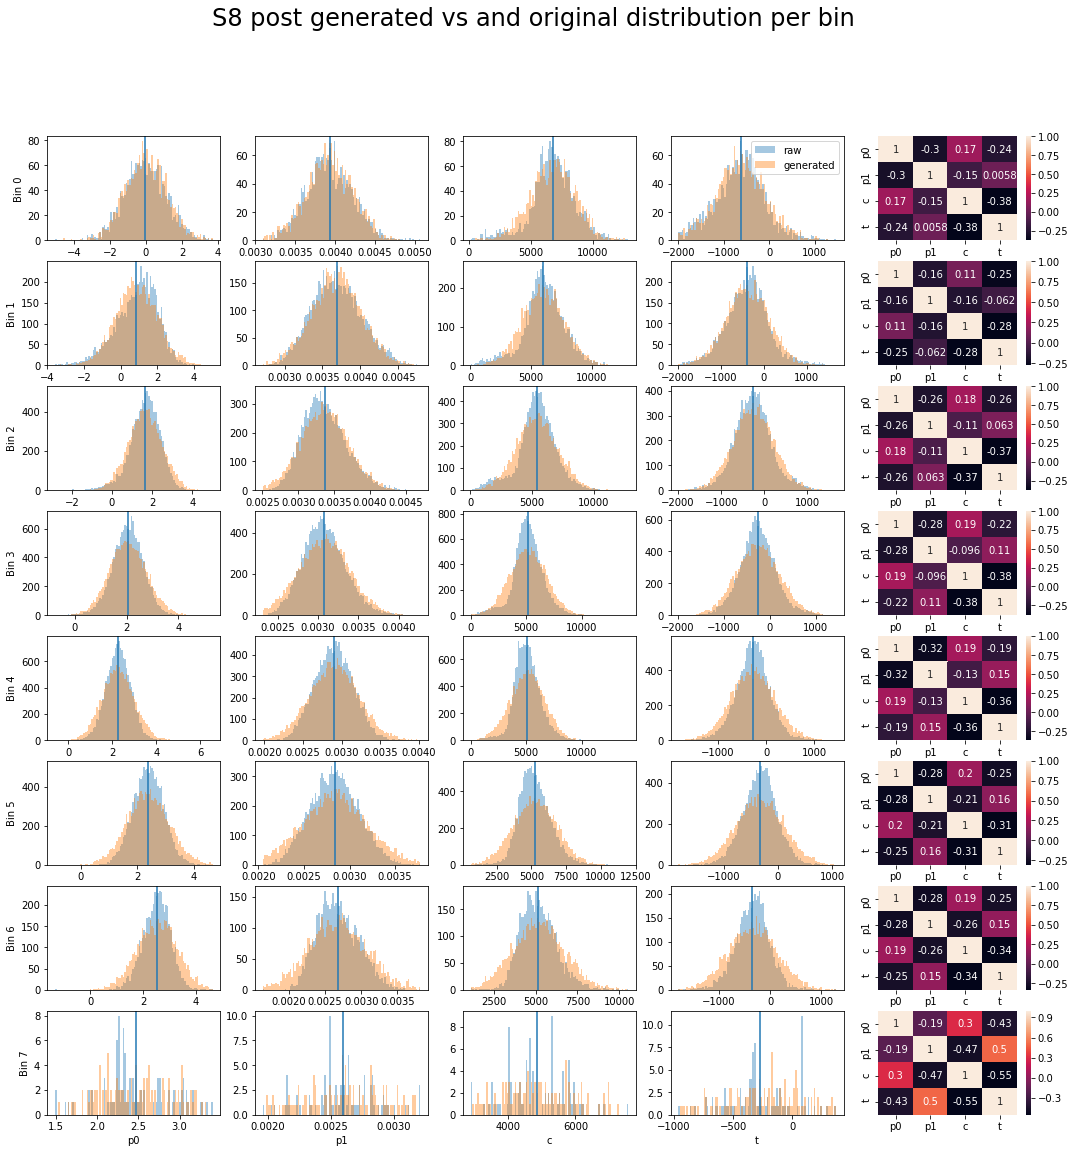

In [40]:
    
fig, ax = plt.subplots(binsize,5, figsize=(18,18))
generated_all = []

genmeans = []
gmeans_dict = {}
surogen_in_bin = {}
corr_in_bin = {}
scaler, pca = SuroGen2.fit_alteration(post)
#generated_to_save_all = {}
#params_in_bin = {}
post_surogen = {}
fig.suptitle("S8 post generated vs and original distribution per bin", fontsize=24)
for i, (name, group) in enumerate(post.groupby('bin')):
    if name==9:
        break
    axes = ax[i]
    pre_params = group[['p0','p1','c','t']]
    pre_cut_bin = cut_range(pre_params)
    surogen = SuroGen2(pca)
    surogen.fit(group)
    corr_in_bin[name] = pre_cut_bin.corr()
    generated = surogen.generate(group.shape[0])
    surogen_in_bin[name] = surogen
    generated_all.append(generated)
    rmi = surogen.means()[0]
    genmeans.append(rmi)
    gmeans_dict[i] = rmi
    #print([v for v in surogen.fit_params.values()])
    #print(rmi)
    axes[0].axvline(rmi[0])
    axes[1].axvline(rmi[1])
    axes[2].axvline(rmi[2])
    axes[3].axvline(rmi[3])
    
    _, b1, _ = axes[0].hist(pre_cut_bin.values[:,0], bins=100, alpha=0.4)
    _, b2, _ = axes[1].hist(pre_cut_bin.values[:,1], bins=100, alpha=0.4)
    _, b3, _ = axes[2].hist(pre_cut_bin.values[:,2], bins=100, alpha=0.4)
    _, b4, _ = axes[3].hist(pre_cut_bin.values[:,3], bins=100, alpha=0.4, label='raw')

    axes[0].hist(generated[:,0], bins=b1, alpha=0.4)
    axes[1].hist(generated[:,1], bins=b2, alpha=0.4)
    axes[2].hist(generated[:,2], bins=b3, alpha=0.4)
    axes[3].hist(generated[:,3], bins=b4, alpha=0.4, label='generated')
    axes[0].set_ylabel("Bin {}".format(name))
    decorelated = surogen.transform(SuroGen.prepare_data(group))
    corrMatrix = pd.DataFrame(data=decorelated, columns=SuroGen._columns).corr()
    sns.heatmap(corrMatrix, annot=True, ax=axes[4])

ax[0,3].legend()
axes[0].set_xlabel('p0')
axes[1].set_xlabel('p1')
axes[2].set_xlabel('c')
axes[3].set_xlabel('t')



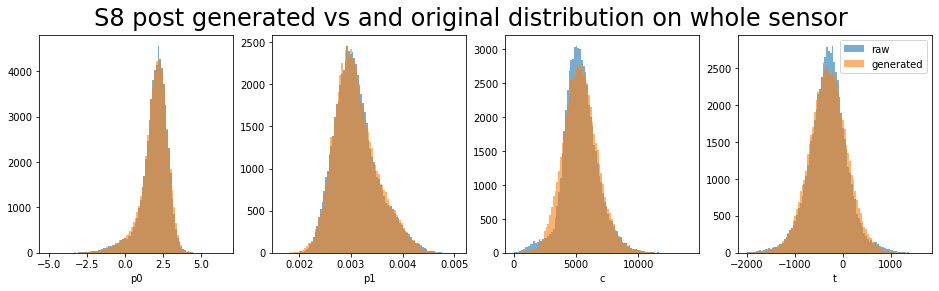

In [14]:
all_gen_arr = np.concatenate(generated_all)
post_cut = post[['p0','p1','c','t']]
post_cut = cut_range(post_cut)

fig, ax = plt.subplots(1,4, figsize=(16,4))
fig.suptitle("S8 post generated vs and original distribution on whole sensor", fontsize=24)
axes = ax
for j in range(4):
    _, b, _ = axes[j].hist(post_cut.values[:,j], bins=100, alpha=0.6, label='raw')
    axes[j].hist(all_gen_arr[:,j], bins=b, alpha=0.6, label='generated')
axes[0].set_xlabel("p0")
axes[1].set_xlabel("p1")
axes[2].set_xlabel("c")
axes[3].set_xlabel("t")
axes[3].legend()

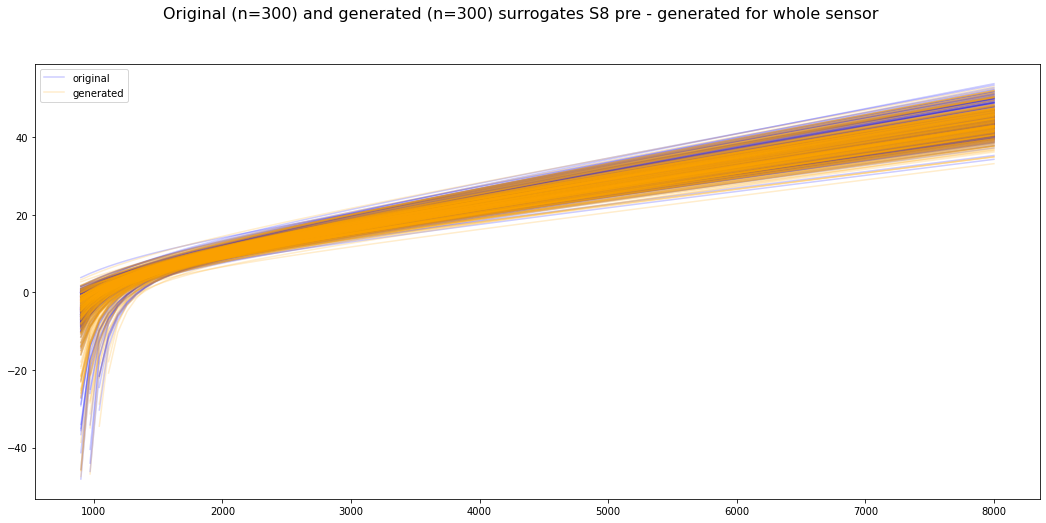

In [15]:
#plt.style.use("bmh")
fig, axes = plt.subplots(1,1,figsize=(18,8), sharey=True)
max_tp_charge = 8000
x = np.linspace(900, max_tp_charge, 100)
p0_range=(-10,10)
p1_range=(0,0.010)
c_range=(0,15000)
t_range=(-2000,3000)
axe = axes
fig.suptitle("Original (n=300) and generated (n=300) surrogates S8 pre - generated for whole sensor", fontsize=16)
sampled_pre = pre_cut.sample(300)
for i,row in sampled_pre.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, color='blue', alpha=0.2)

axe.plot(xfilt,y, color='blue', alpha=0.2, label='original')
recor_sampled = pd.DataFrame(data=recor, index=None, columns=['p0','p1','c','t']).sample(300) 
for i,row in recor_sampled.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, color='orange', alpha=0.2)
    
axe.plot(xfilt,y, color='orange', alpha=0.2, label='generated')
axe.legend(prop={'size': 10})

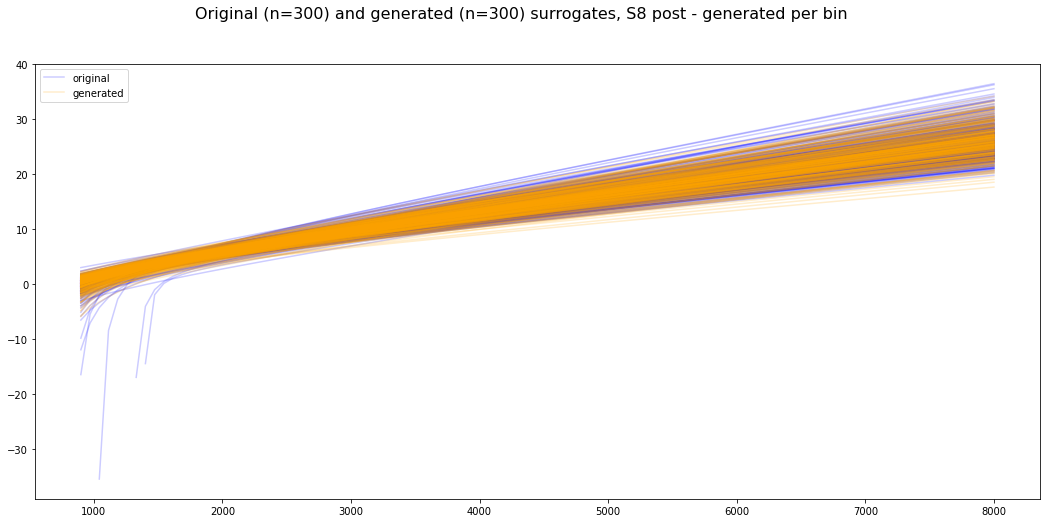

In [28]:
#plt.style.use("bmh")
fig, axes = plt.subplots(1,1,figsize=(18,8), sharey=True)
max_tp_charge = 8000
x = np.linspace(900, max_tp_charge, 100)
p0_range=(-10,10)
p1_range=(0,0.010)
c_range=(0,15000)
t_range=(-2000,3000)
axe = axes
fig.suptitle("Original (n=300) and generated (n=300) surrogates, S8 post - generated per bin", fontsize=16)
sampled_pre = post_cut.sample(300)
for i,row in sampled_pre.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, color='blue', alpha=0.2)

axe.plot(xfilt,y, color='blue', alpha=0.2, label='original')
recor_sampled = pd.DataFrame(data=all_gen_arr, index=None, columns=['p0','p1','c','t']).sample(300) 
for i,row in recor_sampled.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, color='orange', alpha=0.2)
    
axe.plot(xfilt,y, color='orange', alpha=0.2, label='generated')
axe.legend(prop={'size': 10})

In [64]:

genmeans

[array([-3.11777986e-02,  3.92693992e-03,  6.75693767e+03, -6.30463862e+02]),
 array([ 8.76939952e-01,  3.68481748e-03,  6.03346669e+03, -3.84760320e+02]),
 array([ 1.63981591e+00,  3.36718455e-03,  5.39970412e+03, -2.60212614e+02]),
 array([ 2.04000412e+00,  3.07407791e-03,  5.16752558e+03, -2.60087489e+02]),
 array([ 2.27259539e+00,  2.90010576e-03,  5.11156406e+03, -2.72657849e+02]),
 array([ 2.39487727e+00,  2.83584875e-03,  5.26107708e+03, -3.34124982e+02]),
 array([ 2.50789034e+00,  2.68109381e-03,  5.17423893e+03, -3.43652248e+02]),
 array([ 2.47454396e+00,  2.59590443e-03,  4.84875005e+03, -2.72300652e+02])]

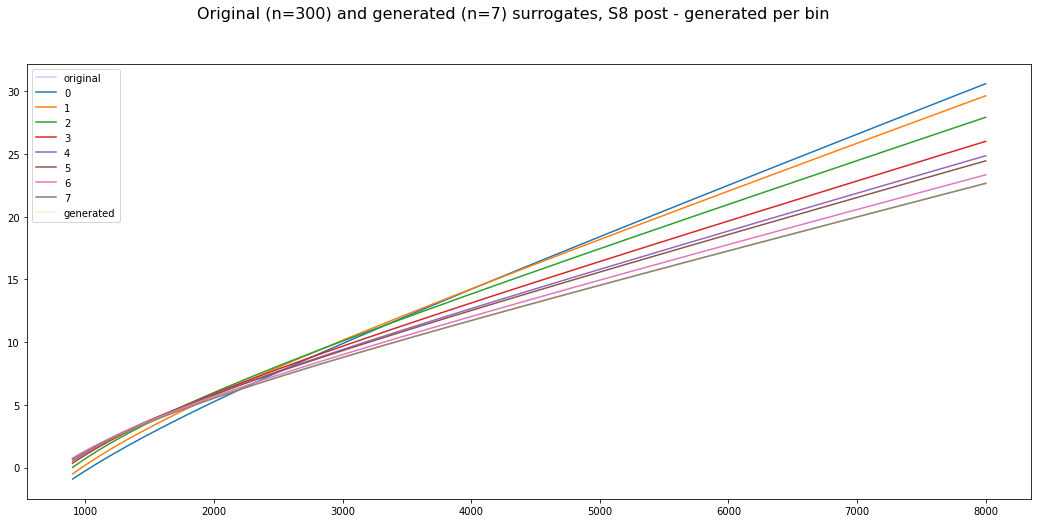

In [63]:
#plt.style.use("bmh")
fig, axes = plt.subplots(1,1,figsize=(18,8), sharey=True)
max_tp_charge = 8000
x = np.linspace(900, max_tp_charge, 100)
p0_range=(-10,10)
p1_range=(0,0.010)
c_range=(0,15000)
t_range=(-2000,3000)
axe = axes
fig.suptitle("Original (n=300) and generated (n=7) surrogates, S8 post - generated per bin", fontsize=16)
sampled_pre = post_cut.sample(300)
for i,row in sampled_pre.iterrows():
    break
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, color='blue', alpha=0.2)

axe.plot(xfilt,y, color='blue', alpha=0.2, label='original')
recor_sampled = pd.DataFrame(data=genmeans, index=None, columns=['p0','p1','c','t'])
for i,row in recor_sampled.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, label=str(i))
    
axe.plot(xfilt,y, color='orange', alpha=0.2, label='generated')
axe.legend(prop={'size': 10})

In [30]:
generated = np.stack(df2['bin'].map(gmeans_dict).values)
gen_df = df2.copy()
gen_df['p0'] = generated[:,0]
gen_df['p1'] = generated[:,1]
gen_df['c'] = generated[:,2]
gen_df['t'] = generated[:,3]

In [31]:
heder = "Charge W0009_G08  \n## fit function ToT = f(q) = [p0 + p1*q - c/(q-t)]\n## col  row   p0   p1   c   t\n"
#del gen_dist['bin']
fname = 'Bin{}_s8_post_generated_by_means.csv'.format(BINNING_TYPE)
with open(fname, 'w') as f:
    f.write(heder)
    del gen_df['bin']
    gen_df.to_csv(f, index=False, sep=' ', header=None, mode='a')

In [32]:
gen_dist = df2.copy()
gen_dist['p0'] = None
gen_dist['p1'] = None
gen_dist['c'] = None
gen_dist['t'] = None
for k,v in enumerate(generated_all):
    gen_dist.loc[gen_dist['bin']==k,['p0','p1','c','t']] = v 

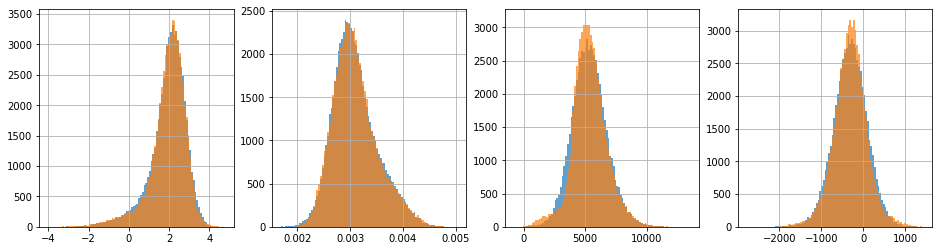

In [33]:
fig, axes = plt.subplots(1,4, figsize=(16,4))
for k, ax in zip(['p0','p1','c','t'], axes):
    _,bins,_ =  ax.hist(gen_dist[k], bins=100, alpha=0.7)
    post_cut[k].hist(bins=bins, alpha=0.7, ax=ax)

In [34]:
heder = "Charge W0009_G08  \n## fit function ToT = f(q) = [p0 + p1*q - c/(q-t)]\n## col  row   p0   p1   c   t\n"
#del gen_dist['bin']
fname = 'Bin{}_s8_post_generated_by_dist.csv'.format(BINNING_TYPE)
with open(fname, 'w') as f:
    f.write(heder)
    del gen_dist['bin']
    gen_dist.to_csv(f,mode='a', index=False, sep=' ', header=None)

# Fitting to fluence

In [62]:
corvals = np.zeros((8,6))
for k,v in surogen_in_bin.items():
    m = corr_in_bin[k].values
    corvals[int(k),0] = m[1,0]
    corvals[int(k),1] = m[2,0]
    corvals[int(k),2] = m[2,1]
    corvals[int(k),3] = m[3,0]
    corvals[int(k),4] = m[3,1]
    corvals[int(k),5] = m[3,2]
    #print(v.pca.explained_variance_)

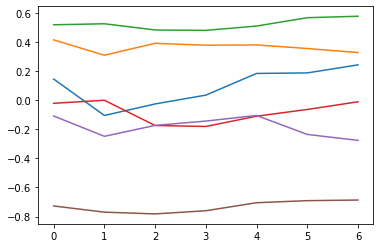

In [66]:
for i in range(6):
    plt.plot(corvals[:7,i])

In [57]:
corvals = np.zeros((8,6))
for k,v in surogen_in_bin.items():
    m = np.abs(corr_in_bin[k])
    #m = corr_in_bin[k]
    corvals[int(k),0] = m[1,0]
    corvals[int(k),1] = m[2,0]
    corvals[int(k),2] = m[2,1]
    corvals[int(k),3] = m[3,0]
    corvals[int(k),4] = m[3,1]
    corvals[int(k),5] = m[3,2]
    #print(v.pca.explained_variance_)

In [58]:
sur

<function common.make_sur.<locals>.<lambda>(x)>

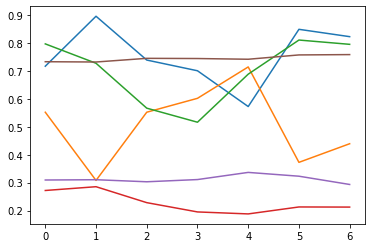

In [59]:
for i in range(6):
    plt.plot(corvals[:7,i])

In [64]:
corvals[0,:]

array([ 0.14556908,  0.41498909,  0.51870813, -0.02111755, -0.10839057,
       -0.72732013])

# Fit no PCA

(8.017443269673064, 4.230921607332307, 3.6489636816853925e-09, 0.9999999950684677)
OrderedDict([('p0', (8.017443269673064, 4.230921607332307, 3.6489636816853925e-09, 0.9999999950684677)), ('p1', (7.830246912818609, 13.754424824795567, 6.578063302504195e-09, 1.0000000101935012)), ('c', (7.909663100834241, 13.914608614856554, -9.978475008083263e-09, 0.9999999968165306)), ('t', (4.320830144835444, 1.581369561056501, 0.000122899710605542, 0.9994850262239698))])
(7.830246912818609, 13.754424824795567, 6.578063302504195e-09, 1.0000000101935012)
OrderedDict([('p0', (8.017443269673064, 4.230921607332307, 3.6489636816853925e-09, 0.9999999950684677)), ('p1', (7.830246912818609, 13.754424824795567, 6.578063302504195e-09, 1.0000000101935012)), ('c', (7.909663100834241, 13.914608614856554, -9.978475008083263e-09, 0.9999999968165306)), ('t', (4.320830144835444, 1.581369561056501, 0.000122899710605542, 0.9994850262239698))])
(7.909663100834241, 13.914608614856554, -9.978475008083263e-09, 0.9999999968

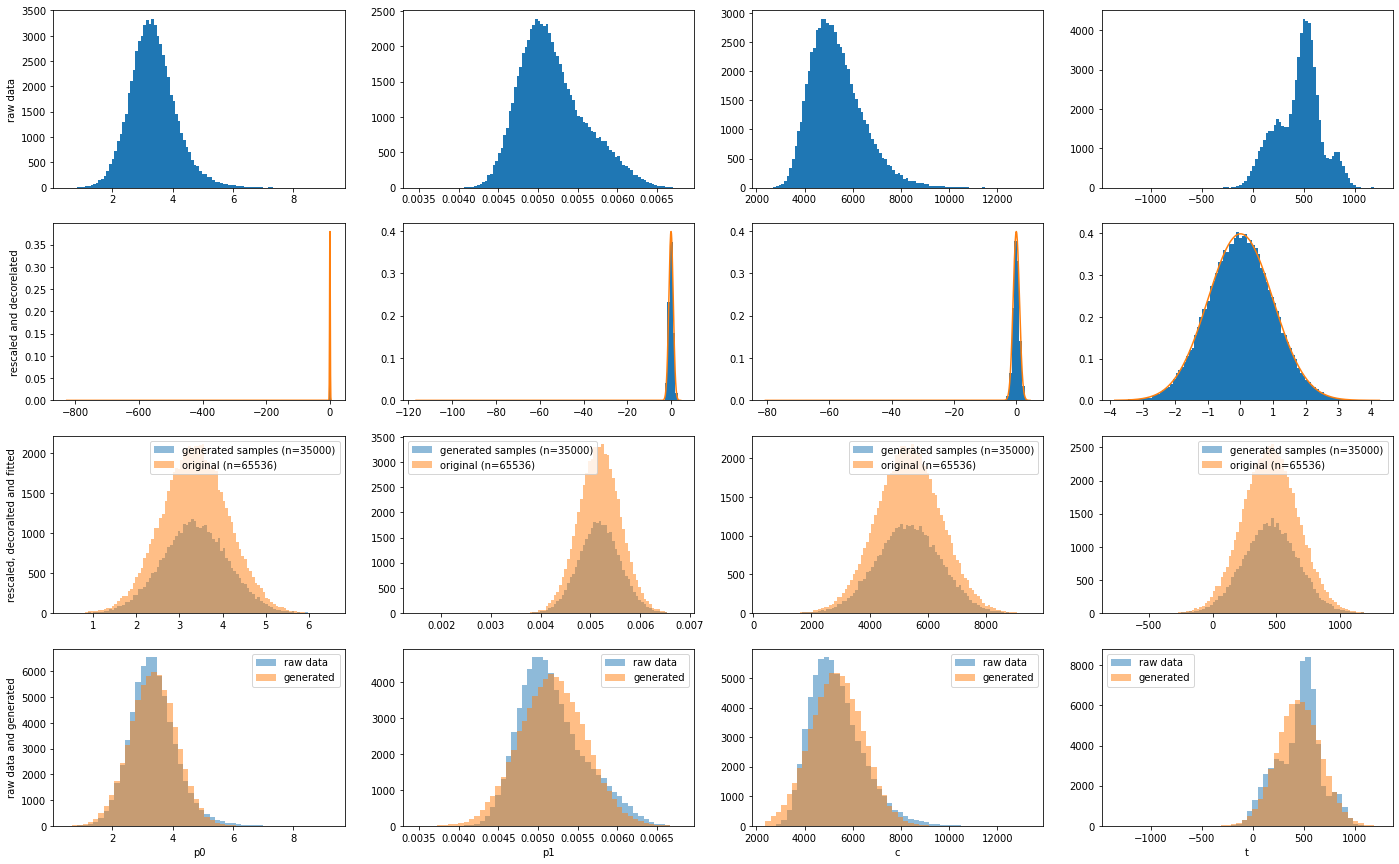

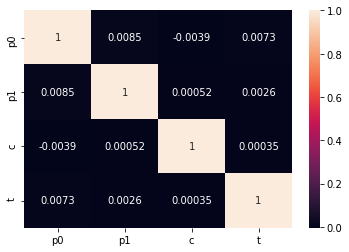

In [17]:
fig, ax = plt.subplots(4,4, figsize=(24,15))

axes = ax[0]
pre_cut = NoPcaSuroGen.prepare_data(pre)
for m in range(4):
    axes[m].hist(pre_cut.values[:,m],bins=100)
    

GENSIZE = pre.shape[0]
axes = ax[3]
tmpbins = []
for m in range(4):
    _, bins, _  = axes[m].hist(pre_cut.values[:,m],bins=50, label="raw data", alpha=0.5)
    tmpbins.append(bins)
    
axes = ax[2]
sgn = NoPcaSuroGen()
sgn.fit(pre)
decorelated = sgn.generate(GENSIZE)

generated = np.zeros_like(decorelated)
axes = ax[1]
unc = sgn._generate(GENSIZE)
_ = axes[0].hist(unc[:,0], bins=100, density=True)
_ = axes[1].hist(unc[:,1], bins=100, density=True)
_ = axes[2].hist(unc[:,2], bins=100, density=True)
_ = axes[3].hist(unc[:,3], bins=100, density=True)


EXAMPLE_GENSIZE = 35000
exmpl = sgn.generate(EXAMPLE_GENSIZE)
for j in range(4):
    data = unc[:,j]
    params = list(sgn.fit_params.items())[j][1]
    print(params)
    print(sgn.fit_params)
    size = 1000 
    x = np.linspace(data.min(), data.max(), size)
    pdf_fitted = sgn.dist.pdf(x, *params) 
    axes = ax[1]
    axes[j].plot(x, pdf_fitted)
    # = dist.rvs(GENSIZE)
    example_gen = exmpl[:,j]
    axes = ax[2]
    _, b,_ = axes[j].hist(example_gen, bins=100, label="generated samples (n={})".format(EXAMPLE_GENSIZE), alpha=0.5)
    axes[j].hist(decorelated[:,j], bins=b, label="original (n={})".format(GENSIZE), alpha=0.5)
    axes[j].legend()
    
    
recor = sgn.generate(GENSIZE)
    
axes = ax[3]
for m in range(4):
    axes[m].hist(recor[:,m],bins=tmpbins[m], label="generated", alpha=0.5)
    axes[m].legend()

ax[0,0].set_ylabel("raw data")
ax[1,0].set_ylabel("rescaled and decorelated")
ax[2,0].set_ylabel("rescaled, decoralted and fitted")
ax[3,0].set_ylabel("raw data and generated")
ax[3,0].set_xlabel("p0")
ax[3,1].set_xlabel("p1")
ax[3,2].set_xlabel("c")
ax[3,3].set_xlabel("t")
fig.show()
import seaborn as sns
plt.figure()
corrMatrix = pd.DataFrame(data=decorelated, columns=SuroGen._columns).corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

[(3.2507222176564365, 3.5649051131441105, 0.0013206353942182506, 0.9971258962920854), (8.991630516141386, 1.0006416257994384, -4.372744591298841e-09, 1.000000002309478), (1.2303990631432893, 53.92216576314811, 0.110183424583782, 0.8577753963786641), (8.219156652907564, 2.964434139733532, 1.9505147078614964e-09, 0.999999996844082)]
[-2.83979218e-02             inf  6.76666164e+03 -6.32644449e+02]
[(8.079781914864363, 1.7098822092976125, -1.6402956103897224e-08, 1.000000005305803), (8.891550136585693, 1.001422712518438, 3.758068267981708e-09, 1.000000009603771), (7.831630858498624, 1.0207887399819109, -7.185029245352315e-09, 0.9999999707333845), (8.069666717377162, 1.6119275597274427, 6.706425224316374e-09, 0.9999999945056368)]
[inf inf inf inf]
[(1.2285518973361902, 45.462930573151176, 0.11191100019595318, 0.8540583229908174), (8.05019239658732, 5.922516096878112, -7.90586607292742e-09, 0.9999999968420006), (7.755524790545724, 7.086725826103768, 8.194318813394039e-09, 0.9999999969962234

/home/mwm/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:8343: RuntimeWarning: divide by zero encountered in power
  ((m - 1)*(m/beta)**(-m)/eb2*p/N)**(1/(1-m)))


OverflowError: (34, 'Numerical result out of range')

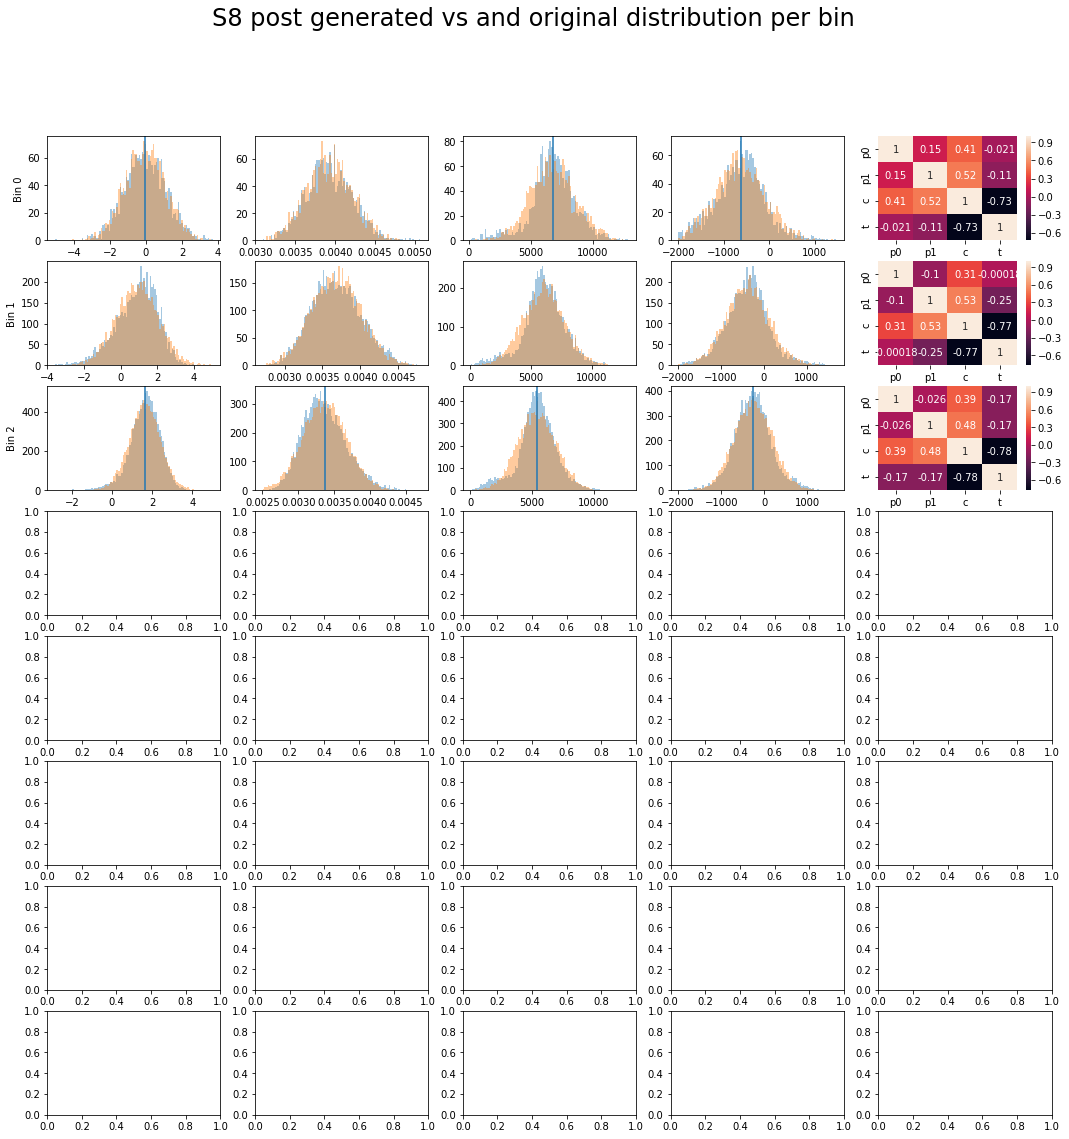

In [18]:
    
fig, ax = plt.subplots(binsize,5, figsize=(18,18))
generated_all = []

genmeans = []
gmeans_dict = {}

#generated_to_save_all = {}
#params_in_bin = {}
post_surogen = {}
fig.suptitle("S8 post generated vs and original distribution per bin", fontsize=24)
for i, (name, group) in enumerate(post.groupby('bin')):
    if name==9:
        break
    axes = ax[i]
    pre_params = group[['p0','p1','c','t']]
    pre_cut_bin = cut_range(pre_params)
    surogen = NoPcaSuroGen()
    surogen.fit(group)
    generated = surogen.generate(group.shape[0])
    #surogen_in_bin[name] = surogen
    generated_all.append(generated)
    rmi = surogen.means()[0]
    genmeans.append(rmi)
    gmeans_dict[i] = rmi
    print([v for v in surogen.fit_params.values()])
    print(rmi)
    axes[0].axvline(rmi[0])
    axes[1].axvline(rmi[1])
    axes[2].axvline(rmi[2])
    axes[3].axvline(rmi[3])
    
    _, b1, _ = axes[0].hist(pre_cut_bin.values[:,0], bins=100, alpha=0.4)
    _, b2, _ = axes[1].hist(pre_cut_bin.values[:,1], bins=100, alpha=0.4)
    _, b3, _ = axes[2].hist(pre_cut_bin.values[:,2], bins=100, alpha=0.4)
    _, b4, _ = axes[3].hist(pre_cut_bin.values[:,3], bins=100, alpha=0.4, label='raw')

    axes[0].hist(generated[:,0], bins=b1, alpha=0.4)
    axes[1].hist(generated[:,1], bins=b2, alpha=0.4)
    axes[2].hist(generated[:,2], bins=b3, alpha=0.4)
    axes[3].hist(generated[:,3], bins=b4, alpha=0.4, label='generated')
    axes[0].set_ylabel("Bin {}".format(name))
    decorelated = surogen.transform(NoPcaSuroGen.prepare_data(group))
    corrMatrix = pd.DataFrame(data=decorelated, columns=SuroGen._columns).corr()
    sns.heatmap(corrMatrix, annot=True, ax=axes[4])

ax[0,3].legend()
axes[0].set_xlabel('p0')
axes[1].set_xlabel('p1')
axes[2].set_xlabel('c')
axes[3].set_xlabel('t')

